In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#loading microstructures and masks

path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\target_1_test\\'
inputs = []
masks=[]
val_images = []
val_masks = []
img_resize = (256,256)
for image in os.listdir(path+'images'): #train images
    img = cv2.imread(path+'images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    inputs.append(img)
    
inputs = np.array(inputs)
inputs = inputs/255
inputs = np.expand_dims(inputs, axis=-1)

for image in os.listdir(path+'masks'):# train masks
    img = cv2.imread(path+'masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    masks.append(img)
    
masks = np.array(masks)
masks = masks/255
masks = np.expand_dims(masks, axis=-1)

for image in os.listdir(path+'val_images'): #validation images
    img = cv2.imread(path+'val_images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    val_images.append(img)
    
val_images = np.array(val_images)  
val_images = val_images/255
val_images = np.expand_dims(val_images, axis=-1)

for image in os.listdir(path+'val_masks'): #validation masks
    img = cv2.imread(path+'val_masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    val_masks.append(img)
    
val_masks = np.array(val_masks)  
val_masks = val_masks/255
val_masks = np.expand_dims(val_masks, axis=-1)

In [3]:
val_masks.shape

(100, 256, 256, 1)

In [4]:
#showing sample training image
cv2.imshow('sample input', inputs[19])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D
from tensorflow.keras.optimizers import SGD

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
model = UNet()
model.compile(optimizer='adam', loss="binary_crossentropy")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 16) 80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 16) 1040        conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_32[0][0]                  
____________________________________________________________________________________________

In [13]:
#log_directory = 'logs\\fit'

In [14]:
from tensorflow.keras.callbacks import EarlyStopping #, TensorBoard
early_stop = EarlyStopping(monitor='val_loss',patience=50)
'''board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)'''

"board = TensorBoard(log_dir=log_directory,histogram_freq=1,\n    write_graph=True,\n    write_images=True,\n    update_freq='epoch',\n    profile_batch=2,\n    embeddings_freq=1)"

In [15]:
model.fit(inputs, masks, epochs=1000, validation_data = (val_images, val_masks) ,callbacks=[early_stop])

Train on 300 samples, validate on 100 samples
Epoch 1/1000
300/300 [==============================] - 9s 31ms/sample - loss: 0.5753 - val_loss: 0.4302
Epoch 2/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.2834 - val_loss: 0.2249
Epoch 3/1000
300/300 [==============================] - 4s 14ms/sample - loss: 0.1964 - val_loss: 0.1796
Epoch 4/1000
300/300 [==============================] - 4s 14ms/sample - loss: 0.1774 - val_loss: 0.1762
Epoch 5/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.1746 - val_loss: 0.1729
Epoch 6/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.1707 - val_loss: 0.1688
Epoch 7/1000
300/300 [==============================] - 4s 14ms/sample - loss: 0.1661 - val_loss: 0.1631
Epoch 8/1000
300/300 [==============================] - 4s 14ms/sample - loss: 0.1613 - val_loss: 0.1603
Epoch 9/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.1590 - val_loss: 0.1582
Epoch 10/

Epoch 78/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0721 - val_loss: 0.0722
Epoch 79/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0720 - val_loss: 0.0721
Epoch 80/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0719 - val_loss: 0.0720
Epoch 81/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0718 - val_loss: 0.0719
Epoch 82/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0717 - val_loss: 0.0719
Epoch 83/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0716 - val_loss: 0.0718
Epoch 84/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0717 - val_loss: 0.0716
Epoch 85/1000
300/300 [==============================] - 5s 16ms/sample - loss: 0.0716 - val_loss: 0.0718
Epoch 86/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0716 - val_loss: 0.0718
Epoch 87/1000
300/300 [=======================

Epoch 155/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0686 - val_loss: 0.0687
Epoch 156/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0685 - val_loss: 0.0686
Epoch 157/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0685 - val_loss: 0.0688
Epoch 158/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0685 - val_loss: 0.0686
Epoch 159/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0684 - val_loss: 0.0688
Epoch 160/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0685 - val_loss: 0.0687
Epoch 161/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0684 - val_loss: 0.0686
Epoch 162/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0684 - val_loss: 0.0685
Epoch 163/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0684 - val_loss: 0.0686
Epoch 164/1000
300/300 [=============

300/300 [==============================] - 4s 15ms/sample - loss: 0.0667 - val_loss: 0.0670
Epoch 308/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0667 - val_loss: 0.0669
Epoch 309/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0666 - val_loss: 0.0669
Epoch 310/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0666 - val_loss: 0.0670
Epoch 311/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0667 - val_loss: 0.0669
Epoch 312/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0666 - val_loss: 0.0668
Epoch 313/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0666 - val_loss: 0.0668
Epoch 314/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0666 - val_loss: 0.0669
Epoch 315/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0666 - val_loss: 0.0670
Epoch 316/1000
300/300 [============================

300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0662
Epoch 460/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0661
Epoch 461/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0661
Epoch 462/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0660
Epoch 463/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0661
Epoch 464/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0657 - val_loss: 0.0662
Epoch 465/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0657 - val_loss: 0.0663
Epoch 466/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0658 - val_loss: 0.0663
Epoch 467/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0657 - val_loss: 0.0660
Epoch 468/1000
300/300 [============================

300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 612/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 613/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0652 - val_loss: 0.0658
Epoch 614/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0653 - val_loss: 0.0657
Epoch 615/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 616/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 617/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 618/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0653 - val_loss: 0.0657
Epoch 619/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0652 - val_loss: 0.0657
Epoch 620/1000
300/300 [============================

300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0655
Epoch 764/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0655
Epoch 765/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0655
Epoch 766/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0649 - val_loss: 0.0654
Epoch 767/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0655
Epoch 768/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0654
Epoch 769/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0654
Epoch 770/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0655
Epoch 771/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0650 - val_loss: 0.0656
Epoch 772/1000
300/300 [============================

300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0655
Epoch 916/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0655
Epoch 917/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0649 - val_loss: 0.0654
Epoch 918/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0653
Epoch 919/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0648 - val_loss: 0.0653
Epoch 920/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0654
Epoch 921/1000
300/300 [==============================] - 4s 15ms/sample - loss: 0.0648 - val_loss: 0.0653
Epoch 922/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0653
Epoch 923/1000
300/300 [==============================] - 5s 15ms/sample - loss: 0.0648 - val_loss: 0.0654
Epoch 924/1000
300/300 [============================

In [16]:
losses = pd.DataFrame(model.history.history)

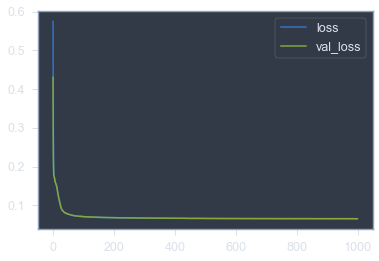

In [17]:
losses[['loss', 'val_loss']].plot()

In [18]:
#loading training set
passed_images = inputs[:10]

In [19]:
#passing training set into network
constructed_masks = model.predict(passed_images)

In [23]:
#predicted masks for training set
n=5
cv2.imshow('original image', cv2.resize(np.squeeze(inputs[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('real mask', cv2.resize(np.squeeze(masks[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('constructed', cv2.resize(np.squeeze(constructed_masks[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.waitKey(0)
cv2.destroyAllWindows()

Testing Individual Validation Image

In [36]:
#edit to change image being evaluated
test_path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\target_1_test\\val_images\\image_15.png'

In [37]:
test =[]
img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
test.append(img)

test = np.array(test)
test = test/255
test = np.expand_dims(test, axis=-1)

In [38]:
img.shape

(256, 256)

In [39]:
#show original test image

cv2.imshow('original image', cv2.resize(np.squeeze(test[0]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.waitKey(0)
cv2.destroyAllWindows()

#show predicted test mask before upscaling
prediction = model.predict(test)
cv2.imshow('predicted mask', cv2.resize(np.squeeze(prediction[0]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
#undo normalization and squeeze to 2by2 array
prediction = np.squeeze(prediction[0]) * 255

In [23]:
#needed for imwrite to work
prediction = prediction.astype('uint8')

In [27]:
prediction = cv2.resize(prediction, (1280, 960), interpolation = cv2.INTER_CUBIC)

cv2.imshow('predicted mask', prediction[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

#uncomment below and change name to save file
#cv2.imwrite('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\constructed masks\\new1.jpg', prediction)

In [ ]:
from tensorflow.keras.models import load_model #to load model

In [22]:
#saving the brain
model.save('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\voronoi.h5')